In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
#import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

#import tensorflow_probability as tfp

#from utils.utils import *
from scipy.fft import dct, idct, ifft2

#plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

2025-07-03 12:36:28.796969: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 12:36:28.938426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-03 12:36:28.938494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-03 12:36:28.961990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 12:36:29.012483: I tensorflow/core/platform/cpu_feature_guar

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
def dct2(a):
	return dct(dct(a.T, norm='ortho').T, norm='ortho')

# implement 2D IDCT
def idct2(a):
	return idct(idct(a.T, norm='ortho').T, norm='ortho')    

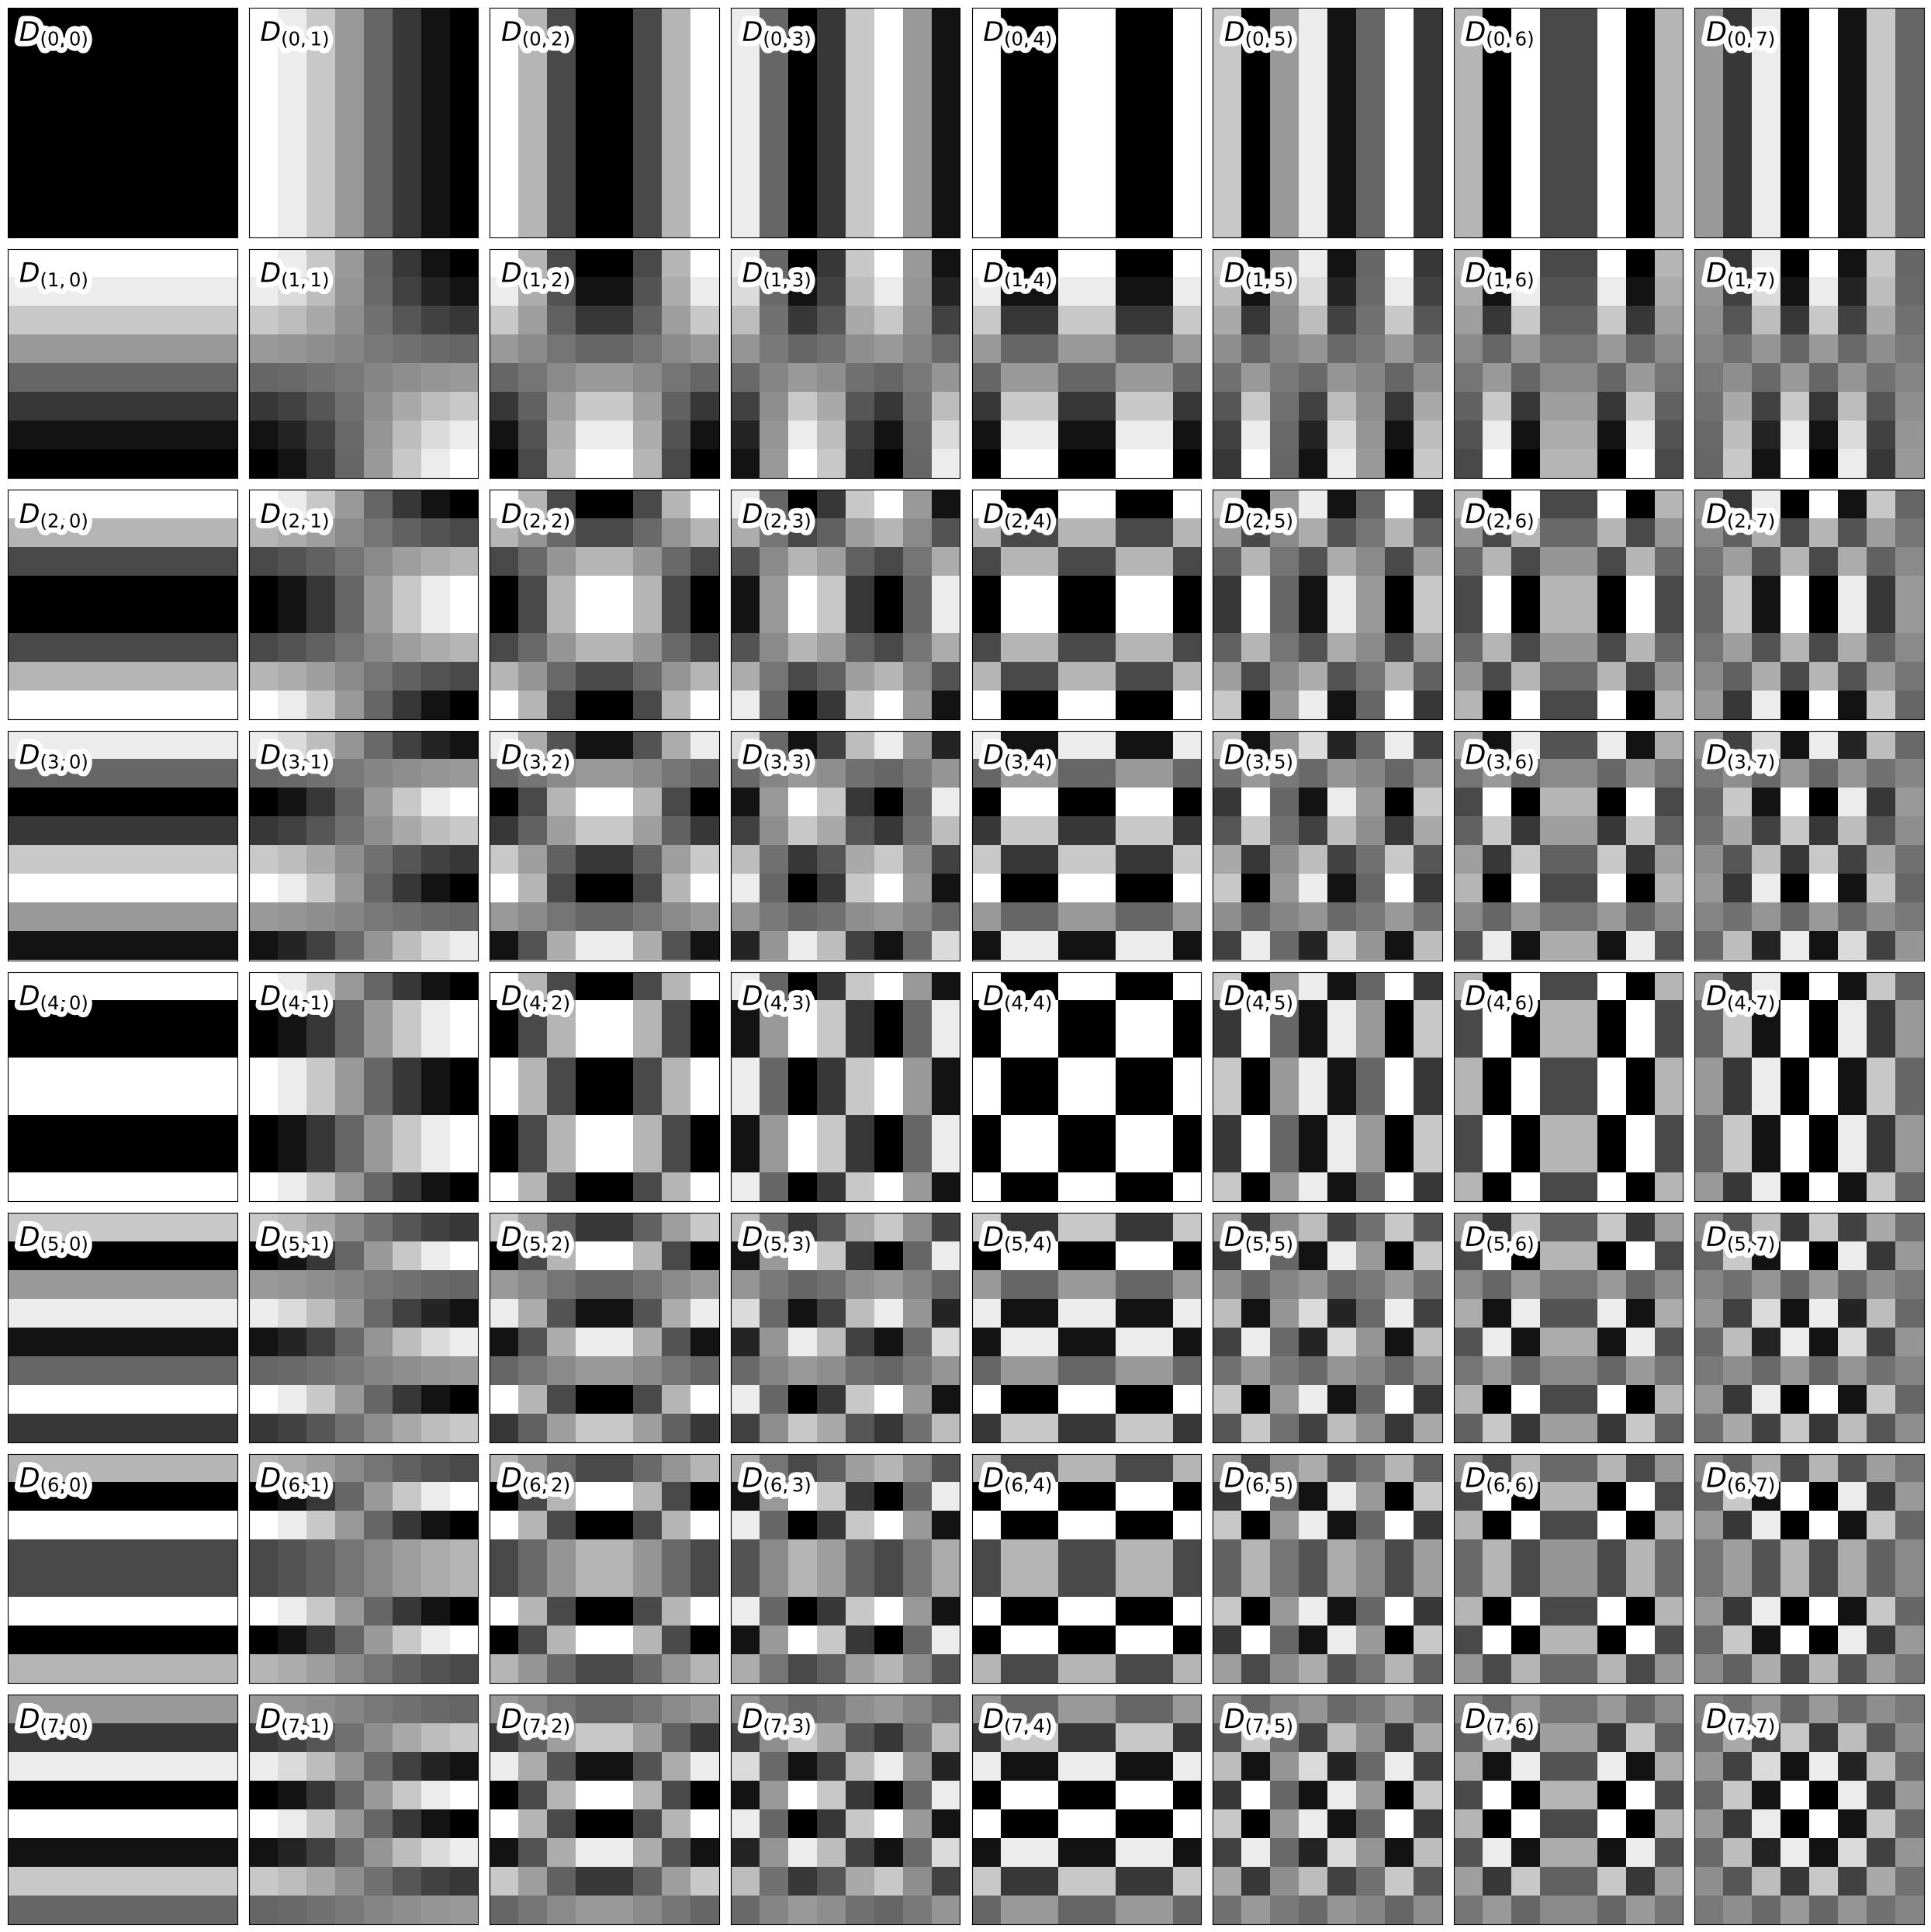

In [3]:
from matplotlib.patches import PathPatch
from matplotlib.text import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as PathEffects

#plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

bins = 8
fig, axes = plt.subplots(8, 8, figsize=(25, 25))

'''vals = np.array([[dc_val, grad_x_val, grad_x2_val], 
 [grad_y_val, saddle_val, mix1_val],
 [grad_y2_val,mix2_val, laplace_val ]])'''


names = [[r'$\Sigma$', r'$\nabla_x$', r'$\nabla_x^2$'],
		 [r'$\nabla_y$', r'$\nabla_x\nabla_y$', r'$\nabla_y\nabla_x^2$'],
		 [r'$\nabla_y^2$', r'$\nabla_x\nabla_y^2$',r'$\nabla_x^2\nabla_y^2$']]

for i in range(0,8):
	for j in range(0,8):
		

		#x0,x1 = axes[i,j].get_xlim()
		#y0,y1 = 0, len(vals[0,0])
		dct_im = np.zeros((8,8))
		dct_im[i,j]=1
		#print(idct2(np.float16(dct_im)))
		#text = "%.4f" % np.mean(vals[i,j])
		axes[i,j].imshow(idct2(np.float16(dct_im)), cmap='gray', aspect='auto',  interpolation='nearest', extent=(0, 255, 0, 255))
		txt = axes[i,j].text(0.05,0.95, f"$D_{{ {i,j} }}$", size=25, color='black', transform=axes[i,j].transAxes, va='top')
		txt.set_path_effects([PathEffects.withStroke(linewidth=10, foreground='w')])

		
		'''font_properties = FontProperties(family="cmb10", style='normal', size=60)
		text_path = TextPath((0,0), text, prop=font_properties)
		
		# Calculate the center of the text
		text_bbox = text_path.get_extents()
		text_width = text_bbox.width
		text_height = text_bbox.height
		center_x = 127.5 - text_width / 2
		center_y = 127.5 - text_height / 2

		# Translate the text path to the centered position
		text_path = TextPath((center_x,center_y), text,  prop=font_properties)


		# Create a PathPatch with a thick white edge (border)
		border_patch = PathPatch(text_path, edgecolor='white', linewidth=10, facecolor='none', antialiased=True)
		axes[i,j].add_patch(border_patch)

		# Create a PathPatch with normal face color (for the main text)
		text_patch = PathPatch(text_path, edgecolor='none', facecolor='black')
		#axes[i,j].add_patch(text_patch)'''

		axes[i,j].set_xticks([])
		axes[i,j].set_yticks([])

plt.tight_layout()
plt.savefig('example_dct.pdf', dpi=600)

plt.show()



In [4]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

vals = np.mean(np.array([dc_val, grad_x_val, grad_y_val, grad_x2_val,  grad_y2_val,saddle_val, mix1_val,mix2_val, laplace_val ]), axis=-1)
print(vals)


fig, ax = plt.subplots()

bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0), (0,1), (1,0), (0,2), (2,0), (1,1), (1,2), (2,1), (2,2)]


for i, bar in enumerate(bars):
    # Load image

    dct_im = np.zeros((3,3))
    dct_im[pos[i]]=1
    print(pos[i])
    #print(idct2(np.float16(dct_im)))
    img = idct2(np.float16(dct_im))

    # Create OffsetImage object
    im = OffsetImage(img, zoom=3)  # Adjust zoom for image size

    # Get the x position of the bar's center
    x_position = bar.get_x() + bar.get_width() / 2

    # Place image below the x-axis label
    ab = AnnotationBbox(im, (x_position, 0), 
                        xybox=(0, -5),  # Adjust the second value for distance under the label
                        xycoords='data', 
                        boxcoords="offset points", 
                        pad=0, frameon=True, 
                        box_alignment=(0.5, 1))

    # Add image to the axes
    ax.add_artist(ab)
ax.set_xticklabels([''] * vals.shape[0])  # Set empty labels
ax.set_xlabel('DCT Component')
ax.xaxis.set_label_coords(0.5, -0.15)
ax.set_ylabel('Avg. Energy \%')
ax.tick_params(axis='x', which='both', length=0)

plt.savefig('figures/vgg16_dct.pdf', dpi=600)
plt.show()

NameError: name 'dc_val' is not defined

In [ ]:
np.sum(vals)

1.0